In [30]:
import QDMpy

In [31]:
import os
import matplotlib.pyplot as plt
import numpy as np

# The data format

The QDMio datafiles can be read with either `scipy.io.loadmat` of `mat73.loadmat` depending on the size (version of matlab file).

In [32]:
from scipy.io import loadmat
from mat73 import loadmat as loadmat73 # for matlab files with version 7.3

In [33]:
# this is a dataset, which has been binned with bin=8. The reflected light and laser images, however are untouched.
# Be aware that binning this set with bin <=8 is not possible.
path_to_the_qdm_datafolder = QDMpy.TEST_DATA_PATH / "utrecht_test_data"

In [34]:
pos_field = loadmat(os.path.join(path_to_the_qdm_datafolder, 'run_00000.mat'))
neg_field = loadmat(os.path.join(path_to_the_qdm_datafolder, 'run_00001.mat'))

# The ODMR object

## creating an instance
### manually

This is a container for the QDM raw ODMR data. A new instance can be created by directly specifying the data, scan_dimensions and frequencies used to measure.

For this, we will need to prepare the data first.

In [35]:
from QDMpy.core import ODMR

The ODMR objects expects the data to be formatted like `[polarity, f_range, n_pixels, n_freqs]` with each on a searate axis, therefor we need to create an array with that composition.

In [36]:
odmr_data = np.array([[pos_field['imgStack1'], pos_field['imgStack2']], [neg_field['imgStack1'], neg_field['imgStack2']]])
odmr_data = odmr_data.swapaxes(-1,-2) # swap pixel/frequency axes
odmr_data.shape

(2, 2, 36000, 51)

(2, 2, 36000, 51)

Lets check that this is correct. The `imgStack2` of the first file (`pos_field`) is the high frequency mesurement range and as such must be the same as index `[0,1]` in the new array. We only need to transpose the array because the QDMio file is stored as [frequency, pixel] and we want [pixel, frequency].

In [37]:
np.allclose(pos_field['imgStack2'].T, odmr_data[0,1])

True

True

The scan_dimensions can be extracted from the `imgNumRows` and `imgNumCols` variables stored in the matlab file.

In [38]:
scan_dimensions = tuple([pos_field['imgNumRows'][0,0], pos_field['imgNumCols'][0,0]])
scan_dimensions

(150, 240)

(150, 240)

We also need to format the frequency list. Here, all frequencies are saved in a single long array, so we split it.

In [39]:
frequencies = np.array([pos_field['freqList'][0,:51], pos_field['freqList'][0,51:]])
frequencies.shape

(2, 51)

(2, 51)

Now we can create a new innstance of the ODMR object.

In [40]:
odmr_manual = ODMR(data=odmr_data, scan_dimensions=scan_dimensions, frequencies=frequencies)

16:14:01     INFO QDMpy._core.odmr.__init__ >> ODMR data object initialized
16:14:01     INFO QDMpy._core.odmr.__init__ >> ODMR data format is [polarity, f_range, n_pixels, n_freqs]
16:14:01     INFO QDMpy._core.odmr.__init__ >> read parameter shape: data: (2, 2, 36000, 51)
16:14:01     INFO QDMpy._core.odmr.__init__ >>                       scan_dimensions: (150, 240)
16:14:01     INFO QDMpy._core.odmr.__init__ >>                       frequencies: (2, 51)
16:14:01     INFO QDMpy._core.odmr.__init__ >>                       n(freqs): 51
16:14:05     INFO QDMpy._core.odmr.__init__ >> ODMR data object initialized
16:14:05     INFO QDMpy._core.odmr.__init__ >> ODMR data format is [polarity, f_range, n_pixels, n_freqs]
16:14:05     INFO QDMpy._core.odmr.__init__ >> read parameter shape: data: (2, 2, 36000, 51)
16:14:05     INFO QDMpy._core.odmr.__init__ >>                       scan_dimensions: (150, 240)
16:14:05     INFO QDMpy._core.odmr.__init__ >>                       frequencies: (2

While this worked fine, when larger fields are applied, the data files have two additional variables `imgStack3` and `imgStack4` due to the larger data (at least in the current version 2022 of the QDM software). This makes the manual creation is more complicated.

Luckily, QDMpy has a more simple option to do all of the above in one line of code.

### Automatic instance creation

Automatic creation is done with the `from_qdmio` method. Furthermore, other data formats can be added to the class by iplementing the `from_other_format` method.

In [41]:
odmr_inst = ODMR.from_qdmio(path_to_the_qdm_datafolder)

16:14:01     INFO QDMpy._core.odmr.from_qdmio >> Reading 2 run_* files.
16:14:02     INFO QDMpy._core.odmr.__init__ >> ODMR data object initialized
16:14:02     INFO QDMpy._core.odmr.__init__ >> ODMR data format is [polarity, f_range, n_pixels, n_freqs]
16:14:02     INFO QDMpy._core.odmr.__init__ >> read parameter shape: data: (2, 2, 36000, 51)
16:14:02     INFO QDMpy._core.odmr.__init__ >>                       scan_dimensions: [150 240]
16:14:02     INFO QDMpy._core.odmr.__init__ >>                       frequencies: (2, 51)
16:14:02     INFO QDMpy._core.odmr.__init__ >>                       n(freqs): 51
16:14:05     INFO QDMpy._core.odmr.from_qdmio >> Reading 2 run_* files.
16:14:05    DEBUG QDMpy._core.odmr.from_qdmio >> Reading file run_00000.mat
16:14:06    DEBUG QDMpy._core.odmr._qdmio_stack_data >> Two ImgStacks found: Stacking data from imgStack1 and imgStack2.
16:14:06    DEBUG QDMpy._core.odmr.from_qdmio >> Reading file run_00001.mat
16:14:06    DEBUG QDMpy._core.odmr._qdmi

The resulting object should have the same data.

In [42]:
np.allclose(odmr_manual.data, odmr_inst.data)

True

True

## Accessing the data
As we have seen in the comparison above, the ODMR data is stored in `ODMR.data`. However, it may be easier to access it using the custom indexing.

In [43]:
# get the low frequency data (left side of the spectrum)
odmr_inst['<']
# get the high frequency data
odmr_inst['>']
# get the positive field data
odmr_inst['+']
# get the negrative field data
odmr_inst['-']

array([[[0.99977747, 0.99997477, 0.99971039, ..., 0.99820958,
         0.99840327, 0.99834935],
        [0.99987568, 0.99978441, 0.99981226, ..., 0.99849667,
         0.99850178, 0.99827344],
        [0.99996246, 0.99955943, 1.        , ..., 0.99859275,
         0.99862117, 0.99849382],
        ...,
        [0.99980955, 1.        , 0.99956842, ..., 0.99887518,
         0.99874418, 0.99878362],
        [1.        , 0.99999192, 0.99985756, ..., 0.99892448,
         0.99881693, 0.99887159],
        [0.99997609, 0.99991979, 0.99987287, ..., 0.99919649,
         0.9987899 , 0.99862442]],

       [[0.99834058, 0.9985715 , 0.99846113, ..., 0.99958003,
         0.9998326 , 1.        ],
        [0.99824017, 0.99819834, 0.99826827, ..., 0.9994389 ,
         0.99980574, 1.        ],
        [0.99848198, 0.9983115 , 0.99842385, ..., 0.99970622,
         0.99957824, 1.        ],
        ...,
        [0.9983692 , 0.9986536 , 0.9986573 , ..., 0.99981282,
         0.99989257, 1.        ],
        [0.9

16:14:06    DEBUG QDMpy._core.odmr.__getitem__ >> get item: <
16:14:06    DEBUG QDMpy._core.odmr.__getitem__ >> ODMR: selected low frequency range
16:14:06    DEBUG QDMpy._core.odmr.__getitem__ >> get item: >
16:14:06    DEBUG QDMpy._core.odmr.__getitem__ >> ODMR: selected high frequency range
16:14:06    DEBUG QDMpy._core.odmr.__getitem__ >> get item: +
16:14:06    DEBUG QDMpy._core.odmr.__getitem__ >> ODMR: selected positive field polarity
16:14:06    DEBUG QDMpy._core.odmr.__getitem__ >> get item: -
16:14:06    DEBUG QDMpy._core.odmr.__getitem__ >> ODMR: selected negative field polarity


array([[[0.99977747, 0.99997477, 0.99971039, ..., 0.99820958,
         0.99840327, 0.99834935],
        [0.99987568, 0.99978441, 0.99981226, ..., 0.99849667,
         0.99850178, 0.99827344],
        [0.99996246, 0.99955943, 1.        , ..., 0.99859275,
         0.99862117, 0.99849382],
        ...,
        [0.99980955, 1.        , 0.99956842, ..., 0.99887518,
         0.99874418, 0.99878362],
        [1.        , 0.99999192, 0.99985756, ..., 0.99892448,
         0.99881693, 0.99887159],
        [0.99997609, 0.99991979, 0.99987287, ..., 0.99919649,
         0.9987899 , 0.99862442]],

       [[0.99834058, 0.9985715 , 0.99846113, ..., 0.99958003,
         0.9998326 , 1.        ],
        [0.99824017, 0.99819834, 0.99826827, ..., 0.9994389 ,
         0.99980574, 1.        ],
        [0.99848198, 0.9983115 , 0.99842385, ..., 0.99970622,
         0.99957824, 1.        ],
        ...,
        [0.9983692 , 0.9986536 , 0.9986573 , ..., 0.99981282,
         0.99989257, 1.        ],
        [0.9

All these can be combined to yield the positive low frequency data, for instance.

In [44]:
odmr_inst['<+']

array([[1.        , 0.99981879, 0.99991575, ..., 0.99821624, 0.99838223,
        0.99828834],
       [0.99992468, 1.        , 0.99999133, ..., 0.99844832, 0.99848963,
        0.99849291],
       [0.99981786, 1.        , 0.99978434, ..., 0.99840744, 0.99851491,
        0.9983014 ],
       ...,
       [0.9999679 , 1.        , 0.99977173, ..., 0.99856427, 0.99861504,
        0.99865983],
       [1.        , 0.99997395, 0.9997494 , ..., 0.99883719, 0.99876319,
        0.99890261],
       [1.        , 0.99982607, 0.99967749, ..., 0.99867732, 0.99856906,
        0.99858889]])

16:14:06    DEBUG QDMpy._core.odmr.__getitem__ >> get item: <+
16:14:06    DEBUG QDMpy._core.odmr.__getitem__ >> ODMR: selected positive field polarity
16:14:06    DEBUG QDMpy._core.odmr.__getitem__ >> ODMR: selected low frequency range


array([[1.        , 0.99981879, 0.99991575, ..., 0.99821624, 0.99838223,
        0.99828834],
       [0.99992468, 1.        , 0.99999133, ..., 0.99844832, 0.99848963,
        0.99849291],
       [0.99981786, 1.        , 0.99978434, ..., 0.99840744, 0.99851491,
        0.9983014 ],
       ...,
       [0.9999679 , 1.        , 0.99977173, ..., 0.99856427, 0.99861504,
        0.99865983],
       [1.        , 0.99997395, 0.9997494 , ..., 0.99883719, 0.99876319,
        0.99890261],
       [1.        , 0.99982607, 0.99967749, ..., 0.99867732, 0.99856906,
        0.99858889]])

If you check the data shape, here all pixels are stored row by row in a long array.

In [45]:
odmr_inst['<+'].shape

(36000, 51)

16:14:06    DEBUG QDMpy._core.odmr.__getitem__ >> get item: <+
16:14:06    DEBUG QDMpy._core.odmr.__getitem__ >> ODMR: selected positive field polarity
16:14:06    DEBUG QDMpy._core.odmr.__getitem__ >> ODMR: selected low frequency range


(36000, 51)

This makes it harder to get the data of the pixel at x = 42, and y = 99 for example. So you can use `'r'` to get the data reshaped into a 2D array.

In [46]:
odmr_inst['<+r'].shape

(150, 240, 51)

16:14:06    DEBUG QDMpy._core.odmr.__getitem__ >> get item: <+r
16:14:06    DEBUG QDMpy._core.odmr.__getitem__ >> ODMR: reshaping data
16:14:06    DEBUG QDMpy._core.odmr.__getitem__ >> ODMR: selected positive field polarity
16:14:06    DEBUG QDMpy._core.odmr.__getitem__ >> ODMR: selected low frequency range


(150, 240, 51)

Now finding the pixel is easy (Note: x = col, y = row and numpy uses [row, col] which can be confusing)

Text(0.5, 0, 'f [GHz]')

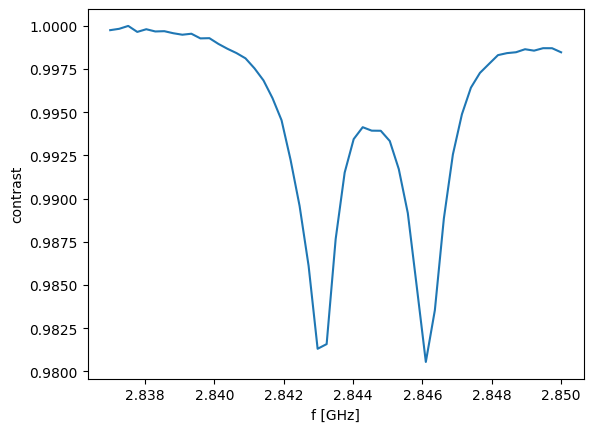

16:14:06    DEBUG QDMpy._core.odmr.__getitem__ >> get item: <+r
16:14:06    DEBUG QDMpy._core.odmr.__getitem__ >> ODMR: reshaping data
16:14:06    DEBUG QDMpy._core.odmr.__getitem__ >> ODMR: selected positive field polarity
16:14:06    DEBUG QDMpy._core.odmr.__getitem__ >> ODMR: selected low frequency range


Text(0.5, 0, 'f [GHz]')

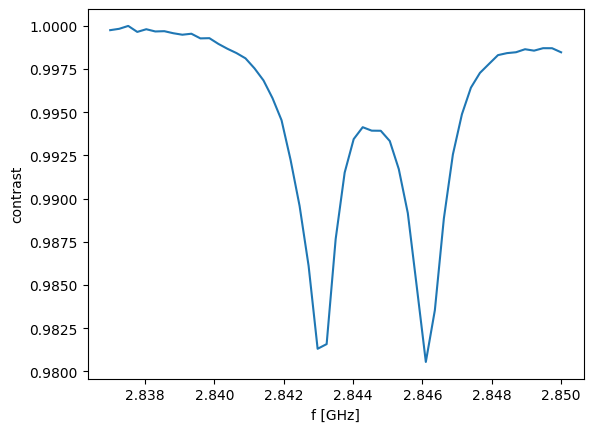

In [47]:
plt.plot(odmr_inst.f_ghz[0], odmr_inst['<+r'][99,42])
plt.ylabel('contrast')
plt.xlabel('f [GHz]')

#### advanced indexing
Obviously you can access te data in `ODMR.data` like any other numpy array, and as we just saw you can index the ODMR object using `'<>+-r'` but you can also use `rc2idx` and `idx2rc` to get the index from row and column values and viceversa.

In teh example above, x = 42 and y = 99 have r = 99 and c = 42. Lets find the index of the corresponding pixel.


In [48]:
idx = odmr_inst.rc2idx((99,42))
idx

23802

23802

This will give you the exact same plot as above.

Text(0.5, 0, 'f [GHz]')

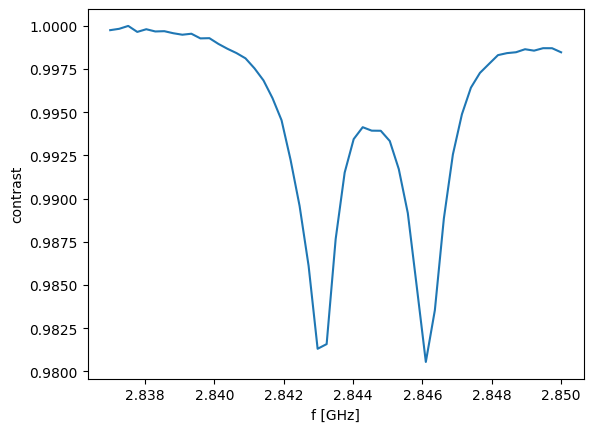

16:14:07    DEBUG QDMpy._core.odmr.__getitem__ >> get item: <+
16:14:07    DEBUG QDMpy._core.odmr.__getitem__ >> ODMR: selected positive field polarity
16:14:07    DEBUG QDMpy._core.odmr.__getitem__ >> ODMR: selected low frequency range


Text(0.5, 0, 'f [GHz]')

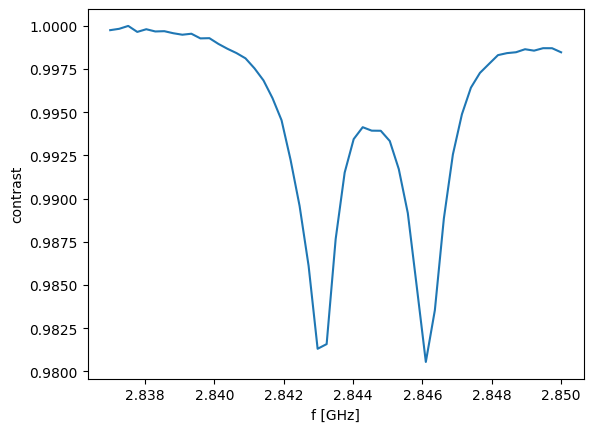

In [49]:
plt.plot(odmr_inst.f_ghz[0], odmr_inst['<+'][idx])
plt.ylabel('contrast')
plt.xlabel('f [GHz]')

Similarly, the method `idx2rc` does the opposite and shour return our x = 42 and y = 99.

In [50]:
odmr_inst.idx2rc(idx)

(array([99], dtype=int64), array([42], dtype=int64))

(array([99], dtype=int64), array([42], dtype=int64))

## Data manipulation
### data binning

In most cases, we use binning to get better signal-to-noise ratio. This also reduces the filesize and all calculations are done more quickly. However, we lose some spatial resolution doing this.

Binning the data is done with `ODMR.bin_data(bin_factor)`.

Note: the dataset 'utrecht_test_data' is already binned with `bin_factor = 8` so that it can be uploaded to the github repository.

In [51]:
odmr_inst.bin_data(bin_factor=2)

16:14:03     INFO QDMpy._core.odmr._bin_data >> Binned data from 2x2x150x240x51 --> 2x2x75x120x51
16:14:07    DEBUG QDMpy._core.odmr._apply_edit_stack >> Applying edit stack
16:14:07    DEBUG QDMpy._core.odmr.reset_data >> Resetting data to raw data.
16:14:07    DEBUG QDMpy._core.odmr.get_norm_factors >> Determining normalization factor from maximum value of each pixel spectrum. Shape of mx: (2, 2, 36000)
16:14:07    DEBUG QDMpy._core.odmr._normalize_data >> Normalizing data with method: max
16:14:07    DEBUG QDMpy._core.odmr._bin_data >> Binning data [150 240] with factor 2 (pre bin factor: 1)
16:14:07     INFO QDMpy._core.odmr._bin_data >> Binned data from 2x2x150x240x51 --> 2x2x75x120x51


AS you can see, this reduces the image from 150x240 -> 75x120. Internally we use `skimage.measure.block_reduce` with `np.nanmean` to calculate the mean of a `bin_factor x bin_factor` window.

You can also reset the binning by just binning again with `bin_factor = 1`.

In [52]:
odmr_inst.bin_data(bin_factor=1)

16:14:04     INFO QDMpy._core.odmr._bin_data >> Binned data from 2x2x150x240x51 --> 2x2x150x240x51
16:14:07    DEBUG QDMpy._core.odmr._apply_edit_stack >> Applying edit stack
16:14:07    DEBUG QDMpy._core.odmr.reset_data >> Resetting data to raw data.
16:14:07    DEBUG QDMpy._core.odmr.get_norm_factors >> Determining normalization factor from maximum value of each pixel spectrum. Shape of mx: (2, 2, 36000)
16:14:07    DEBUG QDMpy._core.odmr._normalize_data >> Normalizing data with method: max
16:14:07    DEBUG QDMpy._core.odmr._bin_data >> Binning data [150 240] with factor 1 (pre bin factor: 1)
16:14:08     INFO QDMpy._core.odmr._bin_data >> Binned data from 2x2x150x240x51 --> 2x2x150x240x51


To see what is happening internally, lets set the logging to debug and run it again.

In [53]:
QDMpy.LOG.setLevel("DEBUG")

In [54]:
odmr_inst.bin_data(bin_factor=1)

16:14:04    DEBUG QDMpy._core.odmr._apply_edit_stack >> Applying edit stack
16:14:04    DEBUG QDMpy._core.odmr.reset_data >> Resetting data to raw data.
16:14:04    DEBUG QDMpy._core.odmr.get_norm_factors >> Determining normalization factor from maximum value of each pixel spectrum. Shape of mx: (2, 2, 36000)
16:14:04    DEBUG QDMpy._core.odmr._normalize_data >> Normalizing data with method: max
16:14:04    DEBUG QDMpy._core.odmr._bin_data >> Binning data [150 240] with factor 1 (pre bin factor: 1)
16:14:04     INFO QDMpy._core.odmr._bin_data >> Binned data from 2x2x150x240x51 --> 2x2x150x240x51
16:14:08    DEBUG QDMpy._core.odmr._apply_edit_stack >> Applying edit stack
16:14:08    DEBUG QDMpy._core.odmr.reset_data >> Resetting data to raw data.
16:14:08    DEBUG QDMpy._core.odmr.get_norm_factors >> Determining normalization factor from maximum value of each pixel spectrum. Shape of mx: (2, 2, 36000)
16:14:08    DEBUG QDMpy._core.odmr._normalize_data >> Normalizing data with method: ma

In [55]:
odmr_inst.bin_data(bin_factor=2)

16:14:04    DEBUG QDMpy._core.odmr._apply_edit_stack >> Applying edit stack
16:14:04    DEBUG QDMpy._core.odmr.reset_data >> Resetting data to raw data.
16:14:04    DEBUG QDMpy._core.odmr.get_norm_factors >> Determining normalization factor from maximum value of each pixel spectrum. Shape of mx: (2, 2, 36000)
16:14:04    DEBUG QDMpy._core.odmr._normalize_data >> Normalizing data with method: max
16:14:04    DEBUG QDMpy._core.odmr._bin_data >> Binning data [150 240] with factor 2 (pre bin factor: 1)
16:14:04     INFO QDMpy._core.odmr._bin_data >> Binned data from 2x2x150x240x51 --> 2x2x75x120x51
16:14:08    DEBUG QDMpy._core.odmr._apply_edit_stack >> Applying edit stack
16:14:08    DEBUG QDMpy._core.odmr.reset_data >> Resetting data to raw data.
16:14:08    DEBUG QDMpy._core.odmr.get_norm_factors >> Determining normalization factor from maximum value of each pixel spectrum. Shape of mx: (2, 2, 36000)
16:14:08    DEBUG QDMpy._core.odmr._normalize_data >> Normalizing data with method: max

As you can see there is quite a lot happening 'under the hood'. Because we are manipulating the data irreversibly, I am using a what I call `edit stack`. If you make any change tho the processing, the whole stack is reapplied. While this is rather time-consuming for larger datasets, it ensures, that nothing unexpected happens to the data.
The stack (so far) is defined as follows:

0. reset the data to original (i.e. the data as it is in the file)
1. normalize the data (`ODMR.normalize_data`)
2. bin the data (`ODMR.bin_data`)
3. apply outlier mask (`apply_outlier_mask`)
4. correct global fluorescence (`correct_global_fluorescence`)

### Global fluorescence correction

ODMR daa also contains an additional signal, which stems from teh internal reflections within a diamond. We call this the global fluorescecne, in contrast to the local fluorescence at the pixel. The total signal, therefore, is `total = global + local`.  This signal is a typically a zero field signal.
We can subtract that signal by specifying the portion of the global signal to the total signal (e.g. 0.2 -> 20% of the total signal is the global fluorescence).

In [61]:
odmr_inst.correct_glob_fluorescence(0.2)

16:15:42    DEBUG QDMpy._core.odmr._apply_edit_stack >> Applying edit stack
16:15:42    DEBUG QDMpy._core.odmr.reset_data >> Resetting data to raw data.
16:15:42    DEBUG QDMpy._core.odmr.get_norm_factors >> Determining normalization factor from maximum value of each pixel spectrum. Shape of mx: (2, 2, 36000)
16:15:42    DEBUG QDMpy._core.odmr._normalize_data >> Normalizing data with method: max
16:15:42    DEBUG QDMpy._core.odmr._bin_data >> Binning data [150 240] with factor 2 (pre bin factor: 1)
16:15:42     INFO QDMpy._core.odmr._bin_data >> Binned data from 2x2x150x240x51 --> 2x2x75x120x51
16:15:42     INFO QDMpy._core.odmr._correct_glob_fluorescence >> Correcting for global fluorescence with value 0.2


If you look closely at the log, you can see that the whole `edit_stack` is again applied. This behavior is unfortunate and should if possible be changed as it takes a lot of time doing this every time.

An easy way to check the way the global_factor affects the signal and wether you have corrected enough/too much, is the `ODMR.check_blob_fluorescence` method. You can specify a new `global_factor` and it will show you a plot of the pixel, that most diverges from the mean (see: `ODMR.get_most_divergent_from_mean`).

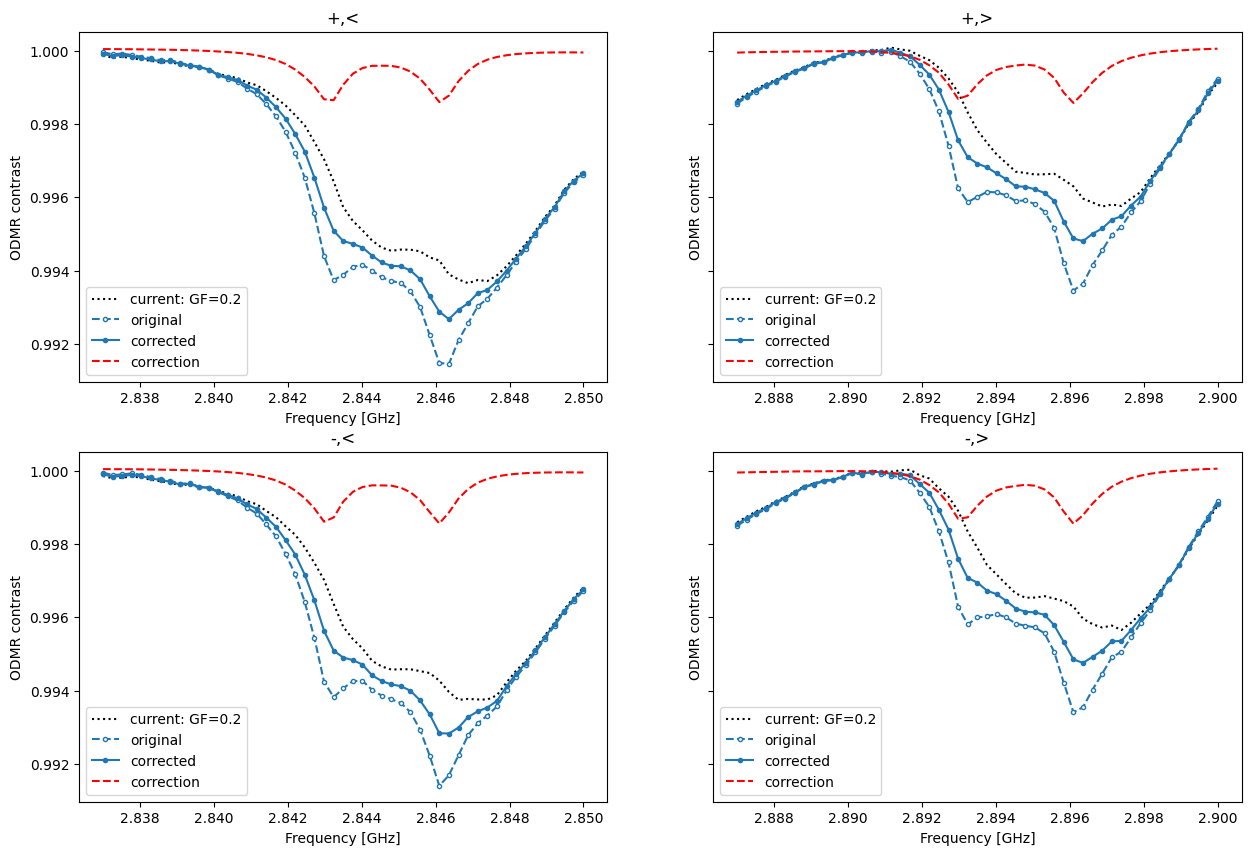

In [64]:
odmr_inst.check_glob_fluorescence(0.1)